In [ ]:
# Essentials
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import os
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm
import soundfile as sf
import matplotlib.pyplot as plt
# Hebrew Package https://pypi.org/project/hebrew/ to install type:pip install hebrew
from hebrew import Hebrew
from hebrew.chars import HebrewChar, ALEPH
from hebrew import GematriaTypes
from HebrewToEnglish2 import HebrewToEnglish
# Audio
from pydub import AudioSegment
from typing import Tuple, List,Set


import pandas as pd
from typing import Tuple, List
import soundfile as sf
%matplotlib inline


def get_duration_in_seconds(audio_path: str) -> float:
    info = sf.info(audio_path)
    return info.frames / info.samplerate

def filter_and_clean_transcripts(metadata: pd.DataFrame, audio_base_path: str) -> Tuple[pd.DataFrame, List[str]]:
    """
    Filters out rows with:
    - transcripts that have fewer than 2 words
    - audio files longer than 20 seconds
    
    Strips whitespace and returns cleaned DataFrame + list of filtered file_ids.
    """
    raw_transcript = metadata[["file_id", "transcript_in_english"]].copy()
    raw_transcript["transcript_in_english"] = raw_transcript["transcript_in_english"].astype(str).str.rstrip()

    # Filter by word count
    word_counts = raw_transcript["transcript_in_english"].str.split().apply(len)
    too_few_words_mask = word_counts < 1

    # Filter by duration
    durations = raw_transcript["file_id"].apply(lambda fid: get_duration_in_seconds(f"{audio_base_path}/{fid}.wav"))
    too_long_audio_mask = durations > 30

    # Combine both masks
    bad_mask = too_few_words_mask | too_long_audio_mask

    # File IDs to remove
    notgood = raw_transcript.loc[bad_mask, "file_id"].tolist()
    
    print(f"Filtered out {len(notgood)} entries with too few words or too long audio.")
    print(f"Total entries before filtering: {len(raw_transcript)}")
    print(f"Total entries after filtering: {len(raw_transcript) - len(notgood)}")

    # Keep only good entries
    raw_transcript = raw_transcript.loc[~bad_mask].reset_index(drop=True)

    return raw_transcript, notgood



def process_audio_files(
    input_path: str,
    output_path: str,
    raw_transcript: pd.DataFrame,
    notgood: Set[str]
) -> pd.DataFrame:
    """
    Processes .wav files: filters based on duration and validity, resamples audio, 
    and builds a cleaned transcript DataFrame.
    
    Args:
        input_path (str): Directory with original .wav files
        output_path (str): Directory to save processed .wav files
        raw_transcript (pd.DataFrame): Clean transcript DataFrame (must include 'file_id' and 'transcript_in_english')
        notgood (Set[str]): Set of file_ids to skip
    
    Returns:
        pd.DataFrame: Cleaned DataFrame with only valid entries
    """
    os.makedirs(output_path, exist_ok=True)
    notgood = set(notgood)  # Ensure it's a set for fast lookup

    file_ids = []
    transcripts = []

    for filename in tqdm(os.listdir(input_path)):
        if not filename.endswith(".wav"):
            continue

        full_path = os.path.join(input_path, filename)
        file_id = filename[:-4]  # remove .wav extension

        if (
            file_id in raw_transcript["file_id"].values and
            get_duration_in_seconds(full_path) >= 0
        ):
            # Resample and save
            y, sr = librosa.load(full_path, sr=22050)
            sf.write(os.path.join(output_path, filename), y, samplerate=22050)

            # Fetch transcript
            row = raw_transcript.loc[raw_transcript["file_id"] == file_id].iloc[0]
            file_ids.append(row["file_id"])
            transcripts.append(row["transcript_in_english"])

    return pd.DataFrame({
        "file_id": file_ids,
        "transcript_in_english": transcripts
    })



def get_dataset_config(set_type: str) -> Tuple[pd.DataFrame, str, str, str]:
    """
    Returns metadata, output filename, input path and output path for given set type.

    Args:
        set_type (str): One of 'train', 'dev'

    Returns:
        metadata (pd.DataFrame): The metadata dataframe
        file_name_output (str): Name of the output text file
        input_path (str): Path to input .wav files
        output_path (str): Path to save processed .wav files
    """
    config = {
        "train": {
            "metadata_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_automatic_data/metadata.csv",
            "input_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_automatic_data/wavs/",
            "output_path": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/data/saspeech_automatic_data/wavs/",
            "file_name_output": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/train_list.txt"
        },
        "dev": {
            "metadata_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_gold_standard/metadata_full.csv",
            "input_path": "/gpfs0/bgu-benshimo/users/wavishay/projects/roboshual/saspeech_gold_standard/wavs/",
            "output_path": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/data/saspeech_gold_standard/wavs/",
            "file_name_output": "/gpfs0/bgu-benshimo/users/wavishay/VallE-Heb/TTS2/tacotron2/dev_list.txt"
        }
    }

    if set_type not in config:
        raise ValueError(f"Unsupported set_type '{set_type}'. Choose from {list(config.keys())}.")

    cfg = config[set_type]
    metadata = pd.read_csv(cfg["metadata_path"], delimiter='|')
    return metadata, cfg["file_name_output"], cfg["input_path"], cfg["output_path"]




# def write_transcript_file(raw_transcript: pd.DataFrame, file_name_output: str, input_path: str) -> None:
#     """
#     Writes the transcript entries to a file in the format:
#     {full_path}/{file_id}|{transcript}.
#     Ensures every transcript ends with a period.

#     Args:
#         raw_transcript (pd.DataFrame): Cleaned DataFrame with file_id and transcript_in_english
#         file_name_output (str): Path to the output text file
#         input_path (str): Full path to the directory where the audio files are stored
#     """
#     with open(file_name_output, 'w', encoding='utf-8') as file:
#         for row in raw_transcript.itertuples(index=False):
#             # Create the full file path by combining the input_path and file_id
#             full_path = os.path.join(input_path, f"{row.file_id}.wav")
#             text = row.transcript_in_english.rstrip()
#             if not text.endswith('.'):
#                 text += '.'
#             # Write the full path and transcript to the file
#             #file.write(f"{full_path}|{text}\n")
#             file.write(f"{full_path}|{text}\n")


def write_transcript_file_mels(raw_transcript: pd.DataFrame, file_name_output: str, input_path: str,notgood) -> None:
    with open(file_name_output, 'w', encoding='utf-8') as file:
        for row in raw_transcript.itertuples(index=False):
            mel_path = os.path.join(input_path, f"{row.file_id}.npy")
            text = row.transcript_in_english.rstrip()
            if not text.endswith('.'):
                text += '.'
            file.write(f"{mel_path}|{text}\n")




# if __name__ == "__main__":
#     set_type_list = ['train','dev']  # or 'train' config

#     for set_type in set_type_list:
        
#         metadata, file_name_output, input_path, output_path = get_dataset_config(set_type)  # set the config for the dataset

#         metadata["transcript_in_english"] = metadata["transcript"].apply(lambda x: HebrewToEnglish(x))  # convert the transcript to english sounds

#         raw_transcript, notgood = filter_and_clean_transcripts(metadata, input_path)  # filter and clean the transcripts
        
#         # # Process the audio files
#         # processed_transcripts = process_audio_files(
#         #     input_path=input_path,
#         #     output_path=output_path,
#         #     raw_transcript=raw_transcript,
#         #     notgood=notgood
#         # )

#        # write_transcript_file(raw_transcript, file_name_output, output_path)  # write the full path transcript to a file
#         output_path = output_path.replace("wavs", "mel_spectrograms")  # change the output path to mels
#         write_transcript_file_mels(raw_transcript, file_name_output, output_path)
        
        
    
# if __name__ == "__main__":
#     set_type = "dev"  # use 'dev' to load the dev metadata

#     # Load dev metadata
#     metadata, file_name_output, input_path, output_path = get_dataset_config(set_type)

#     metadata["transcript_in_english"] = metadata["transcript"].apply(lambda x: HebrewToEnglish(x))
#     raw_transcript, notgood = filter_and_clean_transcripts(metadata)

#     # Shuffle and split the cleaned dev transcripts into 80 train + 20 dev
#     raw_transcript = raw_transcript.sample(frac=1, random_state=42).reset_index(drop=True)
#     split_idx = int(len(raw_transcript) * 0.8)

#     train_subset = raw_transcript.iloc[:split_idx]
#     dev_subset = raw_transcript.iloc[split_idx:]

#     # Save paths (override original file names)
#     train_output_path = output_path.replace("wavs", "mel_spectrograms")
#     dev_output_path = output_path.replace("wavs", "mel_spectrograms")

#     train_list_file = file_name_output.replace("dev_list.txt", "train_80dev_list.txt")
#     dev_list_file = file_name_output.replace("dev_list.txt", "dev_20dev_list.txt")

#     # Write transcript lists using mel paths
#     write_transcript_file_mels(train_subset, train_list_file, train_output_path)
#     write_transcript_file_mels(dev_subset, dev_list_file, dev_output_path)

#     print("Wrote train and dev subsets (80/20) using mel spectrogram paths.")


def plot_duration_histogram(audio_dir: str, bins: int = 50):
    durations = []
    
    for filename in os.listdir(audio_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(audio_dir, filename)
            try:
                duration = get_duration_in_seconds(file_path)
                durations.append(duration)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    if not durations:
        print("No valid .wav files found or all files failed to load.")
        return

    # Plotting the histogram
    plt.hist(durations, bins=bins, edgecolor='black')
    plt.title("Histogram of Audio File Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Files")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
metadata, file_name_output, input_path, output_path = get_dataset_config('train')

plot_duration_histogram(input_path)

metadata, file_name_output, input_path, output_path = get_dataset_config('dev')

plot_duration_histogram(input_path)

NameError: name 'plt' is not defined

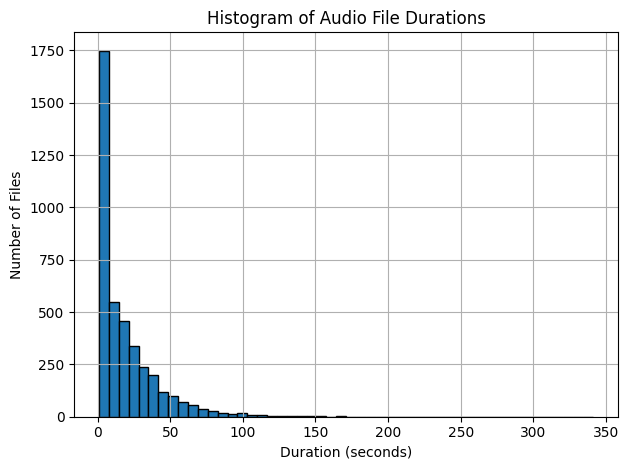

In [2]:

plot_duration_histogram(input_path)

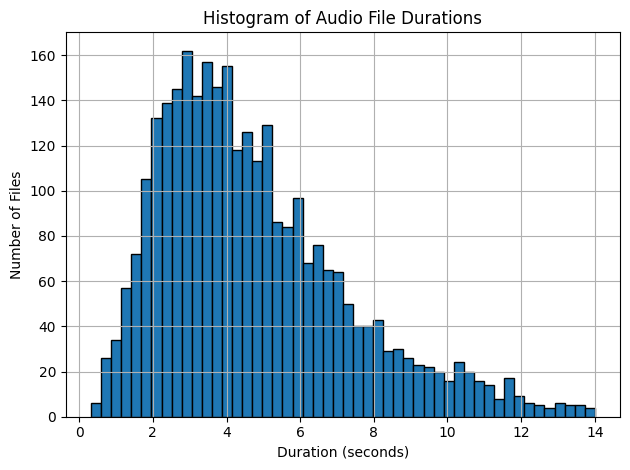

In [3]:
metadata, file_name_output, input_path, output_path = get_dataset_config('dev')

plot_duration_histogram(input_path)